# Interpretability using surrogates

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why.
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why.

In [31]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

## Load data

In [2]:
df = pd.read_csv('datasets\CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# divide data into train and test to avoid data snooping bias
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the random forests model.

In [4]:
# select quantitative features
train_set = train_set[[
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
    'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
    'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
    'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
    'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'
]]

In [5]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_train_imputed = imp_median.fit_transform(train_set)

In [7]:
scaler = Normalizer().fit(df_train_imputed)
df_train_scaled = scaler.transform(df_train_imputed)

## Train machine learning model

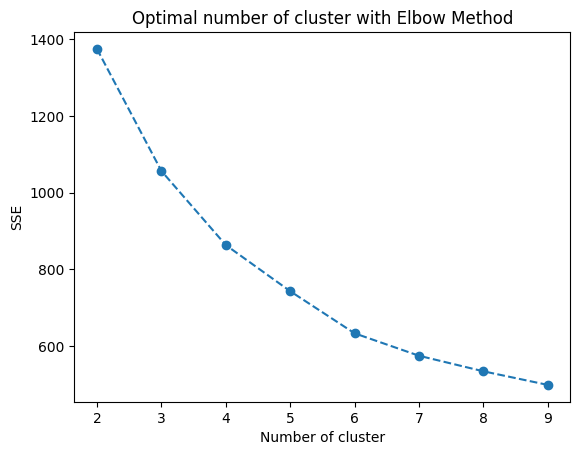

In [8]:
# Choosing optimal K
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_train_scaled)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), linestyle='--', marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.title('Optimal number of cluster with Elbow Method')
plt.show()

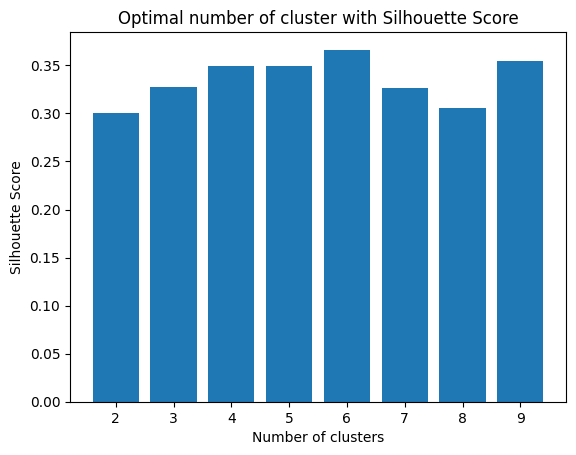

In [9]:
silhouette_scores = [] 

for n_cluster in range(2, 10):
    silhouette_scores.append( 
      silhouette_score(df_train_scaled, KMeans(n_clusters = n_cluster).fit_predict(df_train_scaled))) 
    
# Plotando um gráfico para comparar os resultados 
k = [2, 3, 4, 5, 6, 7, 8, 9] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.title('Optimal number of cluster with Silhouette Score')
plt.show() 

It seems that the number of clusters equal to 4 is fine.

### Train final model

In [11]:
test_set = test_set[[
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
    'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
    'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
    'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
    'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'
]]

In [12]:
df_test_imputed = imp_median.transform(test_set)
df_test_scaled = scaler.transform(df_test_imputed)

In [13]:
kmeans = KMeans(
    n_clusters=4,
    max_iter=1000, 
    random_state=42).fit(df_train_scaled)
    
c_train = kmeans.labels_
c_test = kmeans.predict(df_test_scaled)

In [15]:
pd.Series(c_train).value_counts(normalize=True)

0    0.375181
2    0.245826
1    0.194032
3    0.184961
Name: proportion, dtype: float64

# Evaluate new model in test set

In [14]:
y_pred = c_test.reshape(len(c_test), 1)
b = np.concatenate((y_pred, test_set), axis=1)
df_final = pd.DataFrame(data=b, columns=[
    'Cluster_Num','BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
    'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'])
df_final.head()

<function matplotlib.pyplot.show(close=None, block=None)>

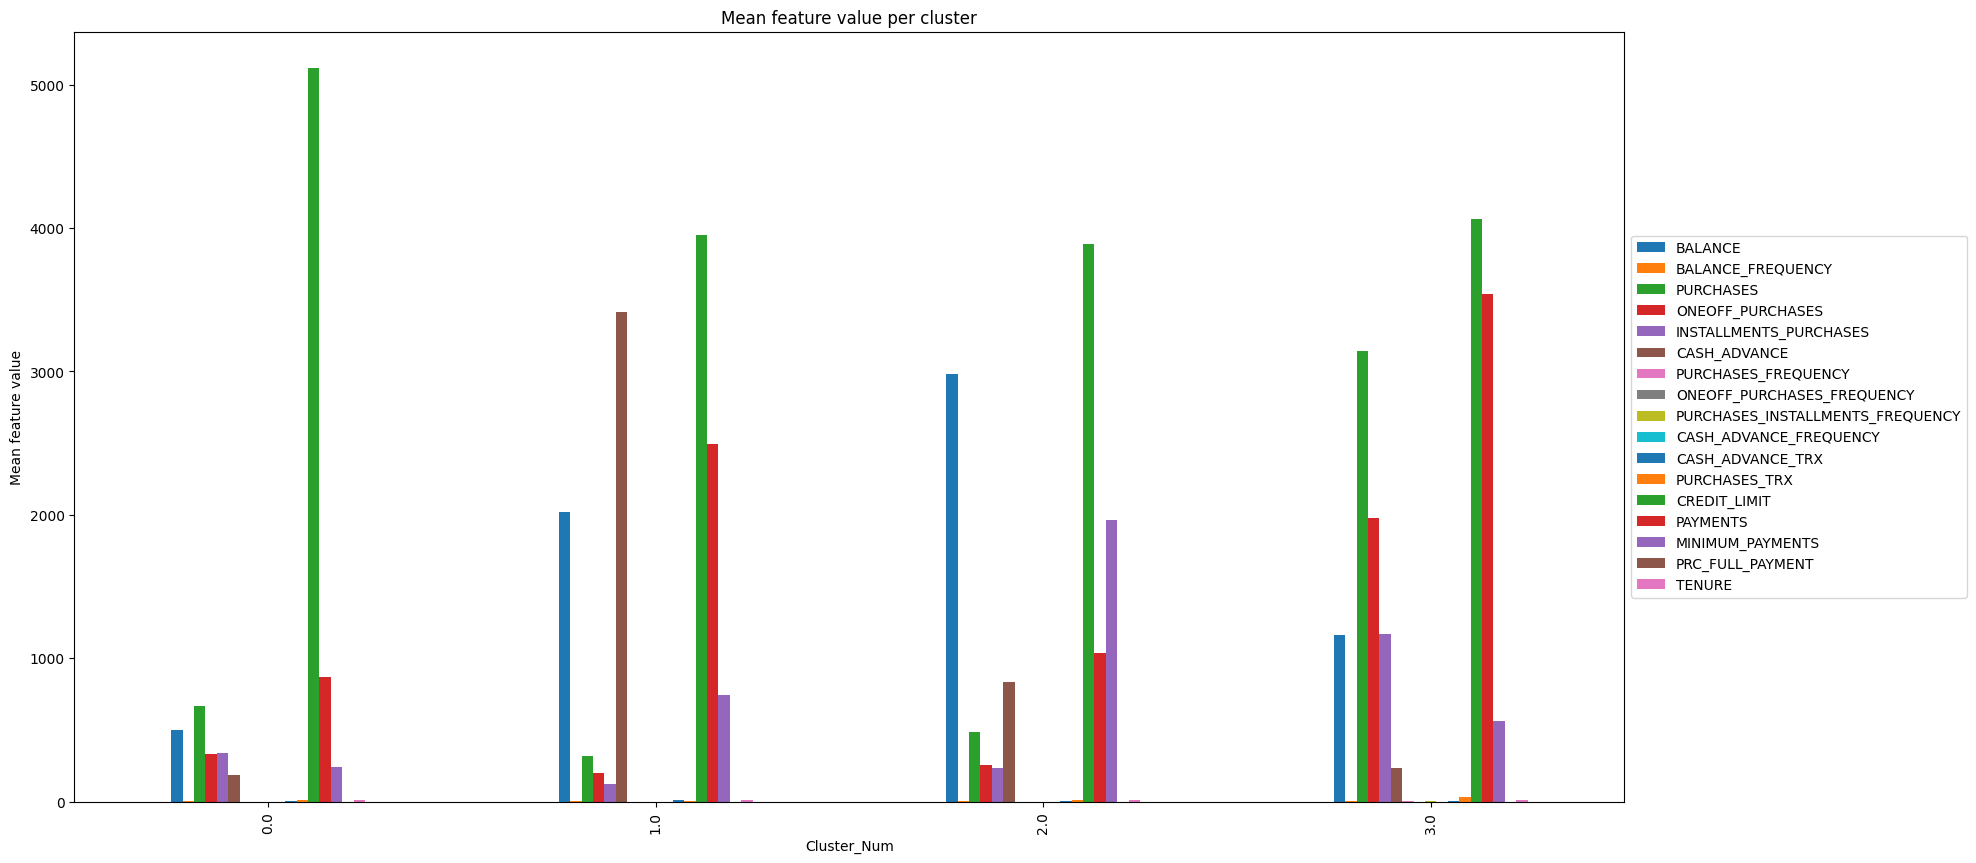

In [20]:
s = df_final.groupby(['Cluster_Num']).mean()
s.plot.bar(figsize=(20,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Mean feature value per cluster")
plt.ylabel("Mean feature value")
plt.show

## Surrogates

Surrogates, if used correctly, are a very simple yet powerful tool to interpet the predictions of black-box models. So what are surrogates?

A surrogate is basically an intrinsically explainable ML model that we train to predict the predictions of a black-box model. Since we can't interpret the predictions of a black-box model intrinsically, the idea here is to take a model that we can actually explain, like a linear regression or a decision tree, and train it to fit the predictions of this black-box. If the surrogate fits the predictions of the black-box well, then by interpreting the white-box model, we can gain insights into how the black-box makes the predictions.

The explanations are obtained by examining the components/coefficients of the surrogate/intrinsically explainable model.

**Mechanism**

* First, we train a black box to predict some data (target is optional: it could be an unsupervised black-box model as well).
* Next, we train an intrinsically explainable model to predict the predictions of the black box. We are going to examine how well the surrogate reproduces the black-box, but then the most important thing is that we will examine the components and parameters of the surrogate to be able to obtain a global explanation of those predictions and also to be able to explain the predictions at a local level.

How are we sure that the surrogate that we train to predict the predictions of our black-box actually reproduces the decisions or the behavior that this black-box has in order to make the predictions?

* For a surrogate to be useful, it needs to approximate the predictions of the black-box model very well. This is a key condition for the use of surrogates, that they fit the predictions of the model that we want to explain very well.
* We evaluate the surrogate's performance as we evaluate any machine learning model's performance.

### Decision tree for interpretation - Surrogate

If you want to know more about how to interpret decision trees, follow the [link](https://github.com/vitorbeltrao/ml-interpretability/blob/main/decision_tree_interpretability.ipynb).

In [35]:
surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(train_set, c_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

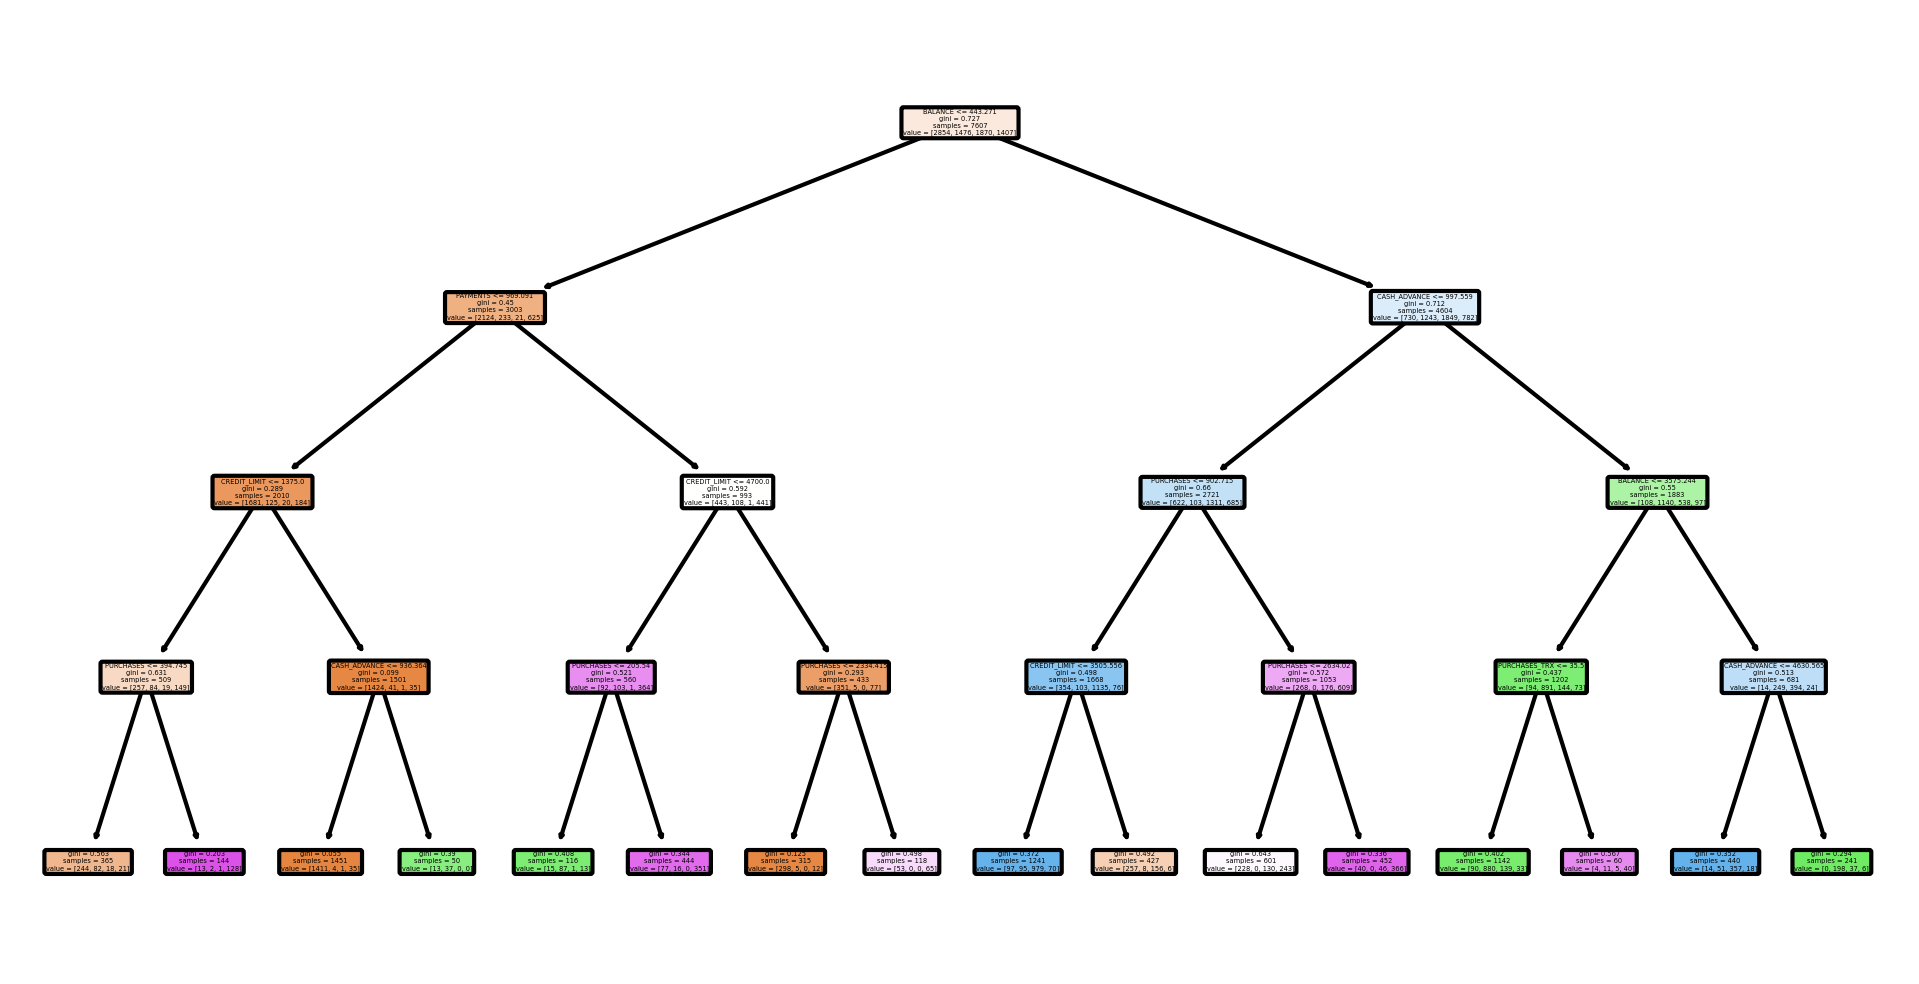

In [40]:
plt.figure(figsize=(8, 4), dpi=300)
plot_tree(
    decision_tree = surrogate,
    feature_names=train_set.columns.to_list(),
    filled=True, # color the squares
    rounded=True # round squares
)
plt.savefig('surrogate', dpi=300)
plt.show()

In [37]:
print(f"Accuracy in train set: {accuracy_score(c_train, surrogate.predict(train_set))}")
print(f"Accuracy in test set: {accuracy_score(c_test, surrogate.predict(test_set))}")

Accuracy in train set: 0.7809911923228605
Accuracy in test set: 0.7557706626954579


In [38]:
print(f"Accuracy in train set: {balanced_accuracy_score(c_train, surrogate.predict(train_set))}")
print(f"Accuracy in test set: {balanced_accuracy_score(c_test, surrogate.predict(test_set))}")

Accuracy in train set: 0.7877641934278873
Accuracy in test set: 0.7640672881599664


The tree has a good accuracy.

### Global explanations

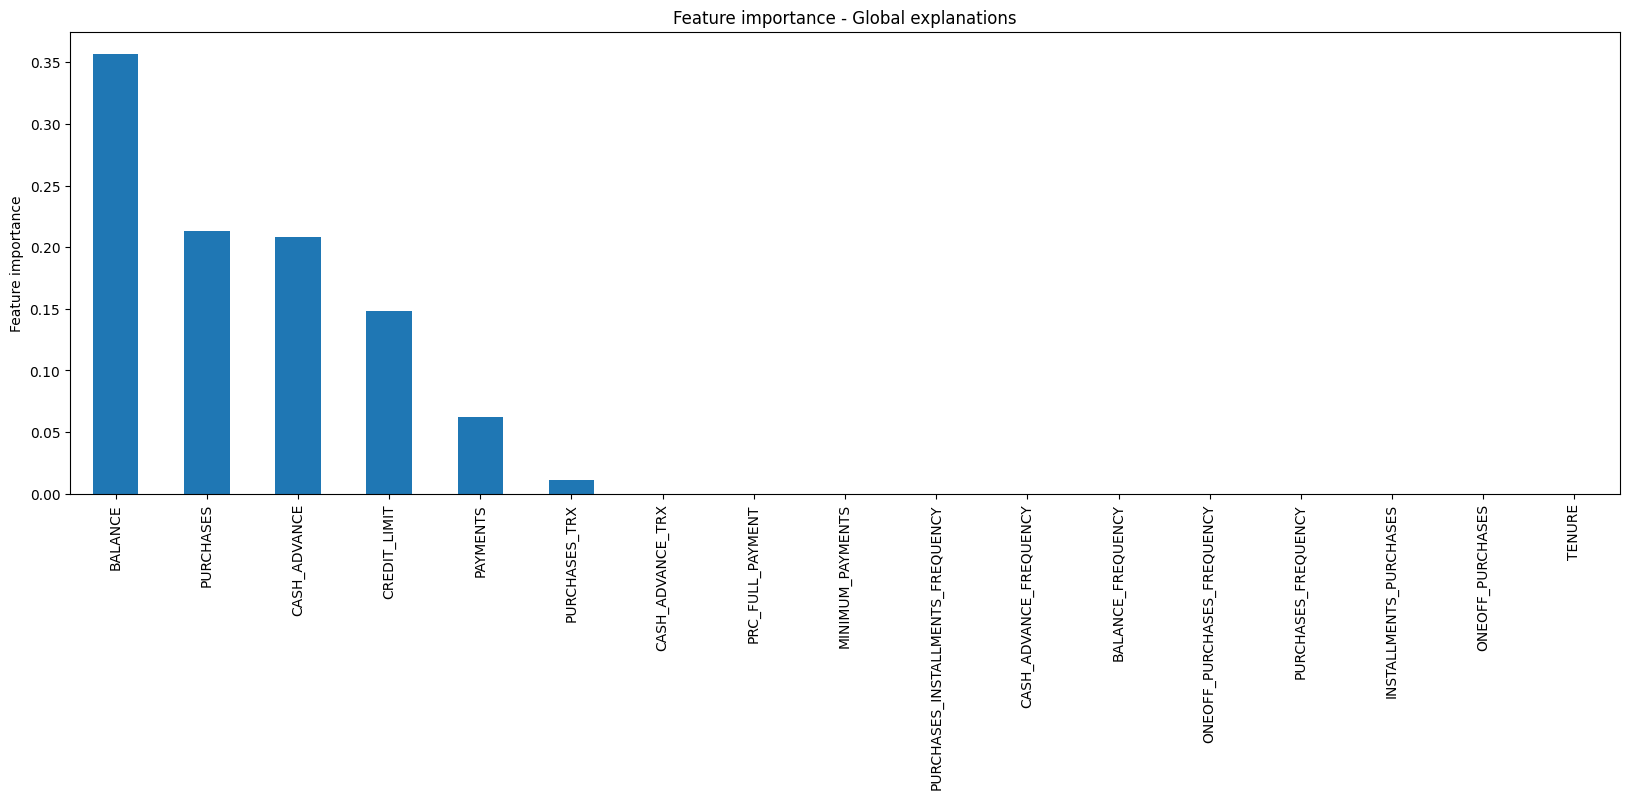

In [41]:
global_exp = pd.Series(
    surrogate.feature_importances_,
    index=surrogate.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

There are mainly 6 features driving the allocation to the different clusters. And as we can see, they are almost the same that we used to characterize the different clusters a couple of cells ago. So far, so good.

So now what?

There are a few things that come to mind to improve the fidelity of the surrogate to the clustering algorithm.

* First, we could look for and remove correlated features and features with low importance.
* Then, I'd re-clusterize the data.
* Then train a tree, optimizing it with cross-validation
* If the accuracy is low, try to improve performance with cost-sensitive learning, or oversampling.

## Conclusion

**Considerations if we're going to use surrogates to interpet black-box models:**

* Surrogates must have high fidelity to the black-box. A surrogate shows high fidelity when it approximates the predictions of the black-box very well.

**How can we better evaluate the surrogate's fidelity to the black box?**

* The key thing to decide the metric that we're going to use to evaluate fidelity is to remember that the surrogate is fitting the predictions of the black-box and not the original target. So we're not interested in our surrogate to make very good classifications of the target, if we're talking about classification, but we're interested in the surrogate approximating the predictions of the black-box very well.
* Surrogate's aim: interpret the black-box regardless of the black-box performance.

**If black-box makes a continuous prediction (inclusing probability):**

* Use continuous metrics (e.g., R², distance metrics -> MSE).

We are not interested in the "classification" power of the surrogate, or how well the surrogate approximates the target. Instead, we are interested in the fidelity of the surrogate, that is, how well it approximates the predictions of the black-box.

**If black-box makes a discrete prediction:**

* Use categorical metrics (e.g., accuracy, f1-score).

**Advantages:**

* We can use any interpretable model.
* We can explain any black-box model.

**Limitations:**

* We can't (ultimately) be sure that the surrogate represent well the black-box.
* If we chose a black-box, probably we thought that an white-box model was not appropriate. So using a white-box to explain the black-box is a bit contradictive.

Using surrogates to explain models that we can explain otherwise, like a random forest or a gradient boosting, makes no sense, because we know already that we can look and explain those models intrinsically by looking at these components and parameters and how they make decisions. But maybe, it's nice to use surrogates to explain black-box models like clustering, anomaly detections models like one-class SVMs and isolation forests within the context of fraud insurance.

**Credits**

https://www.trainindata.com/